In [ ]:
! pip install scikit-surprise


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633971 sha256=7599002a98d794f342c2d321cca268553614784247bc8644cd1f5c10b43646df
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#https://www.youtube.com/watch?v=fEd1p8-3S7w

In [ ]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
from operator import itemgetter
import heapq

import os
import csv
import glob

import pandas as pd

In [ ]:
import glob


# Load data
On charge les différents fichiers de log (dans clicks) et on les fusionne dans un dataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
My_path = '/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P9/news-portal-user-interactions-by-globocom/clicks/clicks/'

In [ ]:
files_input = sorted(glob.glob(My_path+'*csv'))


In [ ]:
list_df = []
for filee in files_input:
  list_df.append(pd.read_csv(filee))
result = pd.concat(list_df)

In [ ]:
result.shape

(2988181, 12)

In [ ]:
data_click = result

In [ ]:
data_click.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [ ]:
# rating <=> session_size : number of click/session
data_click_usefull = data_click[["user_id","click_article_id","session_size","click_timestamp"]]

In [ ]:
data_click_usefull.head()

,user_id,click_article_id,session_size,click_timestamp
0,0,157541,2,1506826828020
1,0,68866,2,1506826858020
2,1,235840,2,1506827017951
3,1,96663,2,1506827047951
4,2,119592,2,1506827090575


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_NaN(data, limite = 0, name='Nombre de \"NaN\" par variable'):
    """
    limite = display col with at least "limite" number of NaN
    """
    nb_nan = data.isna().sum()
    if sum(nb_nan.values) == 0:
      if limite != 0: print("NO NaN, limit set to 0")
      limite = 0
    # pour voir les colonnes avec "nb NaN > limite"
    nb_nan = nb_nan[nb_nan.values >= limite]
    d = {'Variables': nb_nan.index, 'Number of NaN': nb_nan.values} 
    nb_nan_df = pd.DataFrame(data=d)
    plt.figure(figsize=(18, 8))
    nb_nan_df1 = nb_nan_df

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="Variables", y="Number of NaN", data=nb_nan_df1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title(name, fontdict= { 'fontsize': 24, 'fontweight':'bold'})

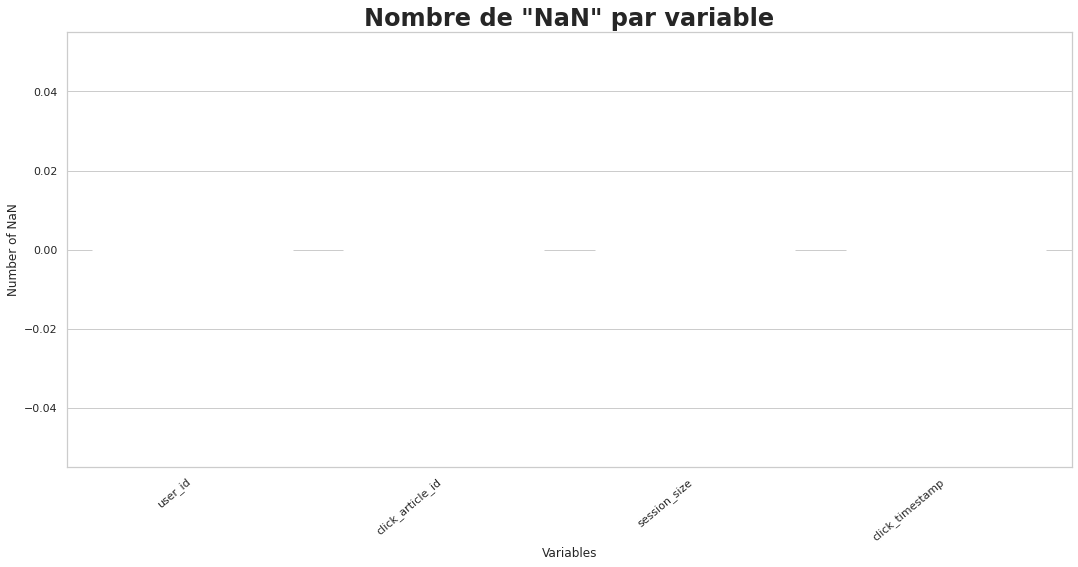

In [ ]:
plot_NaN(data_click_usefull)

**Remarque**: aucune donnée manquante

## Ajout notation
Dans les données, on a pas de notation.\
Pour aider à la suggestion de livre, on va **créer une notation** à partir du nombre de click sur les livres consultés.

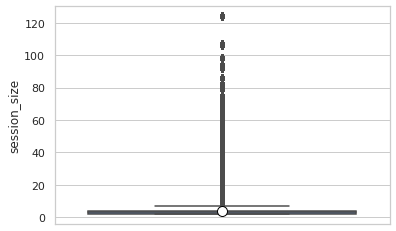

In [ ]:
ax = sns.boxplot(y='session_size', data=data_click_usefull, showmeans=True,
                  meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"10"})

**Remarque**: On a un certain nombre de valeurs qui sortent du lot. On va créer 3 catégories de visionnage de livres. 

In [ ]:
pd.to_numeric(data_click_usefull['session_size']).describe()

count    2.988181e+06
mean     3.901885e+00
std      3.929941e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.240000e+02
Name: session_size, dtype: float64

On créé une note allant de 3 à 5

In [ ]:
data_click_usefull['notation'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_click_usefull['notation'][data_click_usefull['session_size'] <= 3] = 3
data_click_usefull['notation'][data_click_usefull['session_size'] >= 4] = 4
data_click_usefull['notation'][data_click_usefull['session_size'] >= 5] = 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/pytho

In [ ]:
data_click_usefull.drop('session_size', axis=1, inplace=True)
#data_click_usefull.drop('click_timestamp', axis=1, inplace=True) ?

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data_click_usefull

,user_id,click_article_id,click_timestamp,notation
0,0,157541,1506826828020,3
1,0,68866,1506826858020,3
2,1,235840,1506827017951,3
3,1,96663,1506827047951,3
4,2,119592,1506827090575,3
...,...,...,...,...
2564,10051,84911,1508211557302,3
2565,322896,30760,1508211672520,3
2566,322896,157507,1508211702520,3
2567,123718,234481,1508211513583,3


In [ ]:
data_click_usefull.to_csv(My_path+"/tmp/data_click_usefull.csv")

In [ ]:
data_click_usefull_1M = data_click_usefull.iloc[:10000]

In [ ]:
data_click_usefull_1M.shape

(10000, 4)

In [ ]:
# Load in the book ratings and return a dataset.
# parse data in a way that is compatible with our data
reader = Reader(line_format='user item timestamp rating', sep=',', skip_lines=1)


In [ ]:
data = Dataset.load_from_df(data_click_usefull_1M[['user_id', 'click_article_id', 'notation']], reader)

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)


# reco models

## Collaborative filtering (CF) (load pickle)

### load embedding books

In [ ]:
import pickle 

In [ ]:
file_pickle = '/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P9/news-portal-user-interactions-by-globocom/articles_embeddings.pickle'

In [ ]:
with open(file_pickle, 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [ ]:
content

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [ ]:
max(data_click_usefull['click_article_id'])

364046

In [ ]:
content.shape

(364047, 250)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
res = []
for nb_compnt in [10,20,30,40,50,100,200]:
  pca = PCA(n_components=nb_compnt)
  pca.fit(content)
  res.append(sum(pca.explained_variance_ratio_))
res

[0.4952571535658932,
 0.70675916986219,
 0.8302557671132711,
 0.9029398861471748,
 0.9453894988124943,
 0.9872111216629802,
 0.9976474808005509]

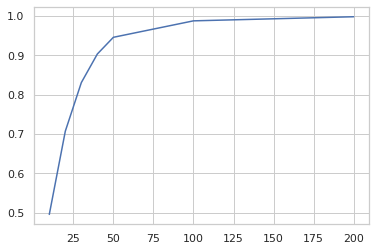

In [ ]:
plt.plot([10,20,30,40,50,100,200], res)

In [ ]:
pca = PCA(n_components=2)

In [ ]:
content_PCA = pca.fit_transform(content)

In [ ]:
pca.explained_variance_ratio_

array([0.09249502, 0.07410808])

In [ ]:
sum(pca.explained_variance_ratio_)

0.16660310766684522

In [ ]:
content_PCA.shape

(364047, 2)

In [ ]:
books_embedding = content_PCA#50 comp

In [ ]:
pd.DataFrame(books_embedding).to_csv(My_path+"/tmp/book_embedding_PCA.csv")

In [ ]:
pd.DataFrame(books_embedding)

,0,1
0,-2.176686,-1.317001
1,-1.735179,0.489917
2,-0.912561,-2.089325
3,1.096778,0.212950
4,0.193792,-0.263905
...,...,...
364042,1.248770,5.252176
364043,0.575216,2.392497
364044,1.564057,4.053483
364045,4.866405,0.151875


### exemple
calcule des distance entre 1 article choisi par rapport aux autres

In [ ]:
#https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101/notebook

In [ ]:
#https://www.datacamp.com/tutorial/recommender-systems-python

In [ ]:
# click_timestamp = Timestamp of the interaction

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

# get top "nb_top" book(s) similar to the last book of "userID"
def user_recommendation(userID = 11, nb_top = 5):
  # compute similarity matrix with the last book of userID
  data_user = data_click_usefull[data_click_usefull['user_id'] == userID]
  last_timestamp = max(data_user['click_timestamp'])

  last_article_click = data_user['click_article_id'][data_user['click_timestamp'] == last_timestamp]

  cosine_sim = linear_kernel([books_embedding[int(last_article_click)]], books_embedding)
  # return top book(s) in the similarity matrix
  top = np.argpartition(cosine_sim[0], -nb_top)[-nb_top:]

  top_croissant = top[np.argsort(cosine_sim[0][top])]

  top_decroissant = top_croissant[::-1] #reverse order
  return top_decroissant

In [ ]:
user_recommendation(userID = 11)

array([103933, 104258, 108038, 102889, 103973])

In [ ]:
user_recommendation(userID = 111)

array([108038, 104258, 150548, 209221, 103291])

## User-Based reco

In [ ]:
#https://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson
distance_metric = 'msd'
distance_metric = 'pearson'
distance_metric = 'pearson_baseline'
distance_metric = 'cosine'


### KNNBasic

In [ ]:
# similarity matrix with KNNBasic on item
similarity_matrix = KNNBasic(sim_options={
        'name': distance_metric,
        'user_based': True
        })

In [ ]:
similarity_matrix.fit(trainset)

In [ ]:
#test RMSE
predictions = similarity_matrix.test(testset)
accuracy.rmse(predictions)

#### exemple

In [ ]:
def user_reco_user_based(userID = 0, nb_top = 10):
  # get "nb_top" closest of user "userID"
  top10_neighborsID = similarity_matrix.get_neighbors(userID,nb_top)
  top10_neighbors = data_click_usefull[data_click_usefull["user_id"].isin(top10_neighborsID) ]

  # return best scored book from each neighbor
  top10_articles = []
  for id in top10_neighborsID:
    topN_neighbor = top10_neighbors[top10_neighbors["user_id"] == id]
    top_books = topN_neighbor[topN_neighbor["notation"] == max(topN_neighbor["notation"])]
    # return last book seen from best scored book
    last_book = top_books[top_books["click_timestamp"] == max(top_books["click_timestamp"])]
    top10_articles.append(int(last_book['click_article_id']))
  return top10_articles

In [ ]:
user_reco_user_based(11)

In [ ]:
user_reco_user_based(111)

In [ ]:
# https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict

In [ ]:
similarity_matrix.predict(0,0)

In [ ]:
top10_neighborsID = similarity_matrix.get_neighbors(0,10)
top10_neighborsID

In [ ]:
top10_neighbors = data_click_usefull[data_click_usefull["user_id"].isin(top10_neighborsID) ]

In [ ]:
top10_articles = []
for id in top10_neighborsID:
  topN_neighbor = top10_neighbors[top10_neighbors["user_id"] == id]
  last_book = topN_neighbor[topN_neighbor["click_timestamp"] == max(topN_neighbor["click_timestamp"])]
  top10_articles.append(int(last_book['click_article_id']))
top10_articles

In [ ]:
predictions[0]